# Homework 3: SQL and Classification (50 points)

**Reading**: Textbook chapter [17](https://www.inferentialthinking.com/chapters/17/Classification).

**Pandas Cheat Sheet**: There are several Pandas documentation files you can find with a simple search. This is one that is short and informative: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.  

Homework 3 is due Wednesday, 2/20 at noon. Late work will not be accepted.  

In [2]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. SQL (24 points) ##

We are going to use SQL to analyze data on NBA player statistics and salaries. First we are going to set up our connection to the SQLite database and remove any previous copies of our tables that may have been left in there.  Then we'll load the tables with data from .csv files.


In [ ]:
# Don't change this cell; just run it.

#Let's connect to our database system and clean up previous tables if they exist
import sqlalchemy

# pd.read_sql takes in a parameter for a SQLite engine, which we create below
sqlite_uri = "sqlite:///basketball.db"
sqlite_engine = sqlalchemy.create_engine(sqlite_uri)

#start with an empty database - DROP the tables if they
#already exist in the database (from a previous run)
sql_expr = """
DROP TABLE IF EXISTS players;
"""
result = sqlite_engine.execute(sql_expr)


sql_expr = """
DROP TABLE IF EXISTS salaries;
"""
result = sqlite_engine.execute(sql_expr)


#### Table Creation
Now that we have a clean database, we can create and load our two tables: `players`, which contains information about NBA basketball players, and `salaries`, which contains information about NBA player's salaries.  Our salary data only includes information for players whose salary is $1M or higher.

In [ ]:
# Don't change this cell; just run it.
#read csv file into a dataframe
players_df = pd.read_csv('player_data.csv')

# Populate players table
temp = players_df.to_sql('players', con=sqlite_engine)

#read csv file into a dataframe
salaries_df = pd.read_csv('salary_7figplus_data.csv')

# Populate salaries table
temp = salaries_df.to_sql('salaries', con=sqlite_engine)

#### Check the tables
Before we start, let's look at what's in our tables

In [ ]:
# Don't change this cell, just run it - to see what's in the players table.
sql_expr = """
SELECT *
FROM players;
"""

pd.read_sql(sql_expr, sqlite_engine).head()

In [ ]:
# Don't change this cell, just run it - to see what's in the salaries table.
sql_expr = """
SELECT *
FROM salaries;
"""
pd.read_sql(sql_expr, sqlite_engine).head()

#### Question 1.1 (Basic Query, 4 points)

Write a SQL statement that returns the Name, Team, Games and Points for all 
players who have played in 70 games or more, sorted in descending order by number of points. 

In [ ]:
# Put your SQL statement in the "sql_expr" variable
sql_expr = """
SELECT Name, Team, Games, Points
FROM players
WHERE Games > 69
ORDER BY Points DESC
;

"""

pd.read_sql(sql_expr, sqlite_engine)

#### Question 1.2 (Summary Statistics (aggregate functions), 4 points)

Write a SQL statement that returns 
a single row containing the average number of Rebounds, Assists, and Points across all players in the players table.  (Note: the SQL "AVG" aggregate function is helpful here) 


In [ ]:
# Put your SQL statement in the "sql_expr" variable

sql_expr = """
SELECT AVG(Rebounds), AVG(Assists), AVG(Points)
FROM players
;


"""

pd.read_sql(sql_expr, sqlite_engine)

#### Question 1.3 (Grouping, 4 points)
Write a SQL statement that returns for each team, the Name of the team and the count of players for that team. Order your answer by descreasing number of players (that is, from the team with the most players to the team with the least).  Your answer should contain one row for each team that appears in the players table.

In [ ]:
# Put your SQL statement in the "sql_expr" variable

sql_expr = """
SELECT Team, COUNT(Name) as Players
FROM players
GROUP BY Team
ORDER BY Players DESC
;

"""

pd.read_sql(sql_expr, sqlite_engine)

#### Question 1.4 (Grouping and Predicates, 4 points)
If your query for question 1.3 worked, then you should see that one "Team" has many more players than any other team.  This value for "Team" turns out to be a special code that indicates that a player played on multiple teams during the year.   Answer the same question as in Question 1.3, but this time, do not include the players that have that special team code.

In [ ]:
# Put your SQL statement in the "sql_expr" variable

sql_expr = """
SELECT Team, COUNT(Name) as Players
FROM players
WHERE Team != 'TOT'
GROUP BY Team
ORDER BY Players DESC

"""

pd.read_sql(sql_expr, sqlite_engine)

#### Question 1.5 (Joins (Inner), 4 points)
Write a SQL statement that returns a row for **each player who has a salary**, that has the Name, Team, Points,and Salary of that player and order the result in **descending order of Salary**.


In [ ]:
# Put your SQL statement in the "sql_expr" variable

sql_expr = """
SELECT Name, Team, Points, Salary
FROM players
INNER JOIN salaries ON players.Name = salaries.PlayerName
ORDER BY Salary DESC
;
"""

pd.read_sql(sql_expr, sqlite_engine)

#### Question 1.6 (Joins (Outer), 4 points)
Similarly to Question 1.5, write a SQL statement that returns a row **for each player** (**whether or not they have a salary**), that has the Name, Team, Points,and Salary of that player.  For players without a salary, the salary can be left as a Null or "NaN". Order your answer in **descending order of salary**.

In [ ]:
# Put your SQL statement in the "sql_expr" variable

sql_expr = """
SELECT Name, Team, Points, Salary
FROM players
LEFT OUTER JOIN salaries ON players.Name = salaries.PlayerName
;
"""


pd.read_sql(sql_expr, sqlite_engine)

## 2. Classification: Autos (26 points) ##

The data below contains 392 observations on the following 9 variables:
-    mpg: miles per gallon

-     cylinders: Number of cylinders between 4 and 8

-     displacement: Engine displacement (cu. inches)

-     horsepower: Engine horsepower

-     weight: Vehicle weight (lbs.)

-     acceleration: Time to accelerate from 0 to 60 mph (sec.)

-     year: Model year (modulo 100)

-     origin: Origin of car (1. American, 2. European, 3. Japanese)




In [3]:
# this commands loads the data into a data frame
auto_df=pd.read_csv("auto.csv")
auto_df.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl


#### Question 2.1 ( Binarization, 3 points)

Create a new column in the data frame containing a binary variable called **mpg_b**: it should be equal to 1 if **mpg** contains a value above its median and equal to 0 if **mpg** contains a value below its median.

In [4]:
# code here and in additional cells if needed

mpg_b = []
mpg_median = auto_df['mpg'].median()

for i in auto_df['mpg']:
    if i > mpg_median:
        mpg_b.append('1')
    elif i <= mpg_median:
        mpg_b.append('0')
        
auto_df['mpg_b'] = mpg_b       

mpg_b
auto_df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_b
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0


#### Question 2.2 (Numerical and graphical summaries, 7 points)

Explore the data graphically (and numerically if you think it is useful) in order to investigate the association between **mpg_b** and the other features.  Which of the other features seem most likely to be useful in predicting **mpg_b**? Describe your findings.


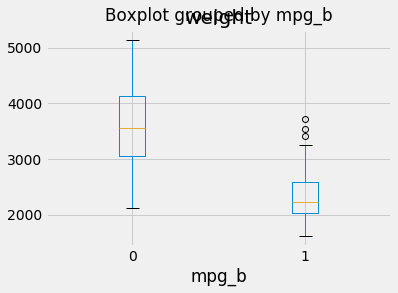

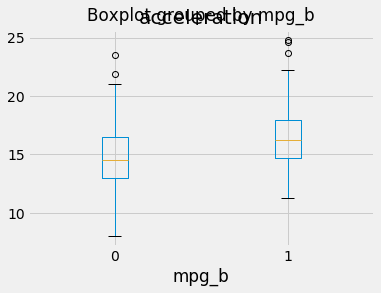

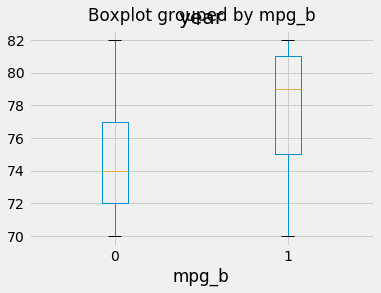

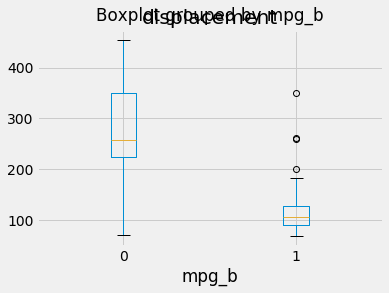

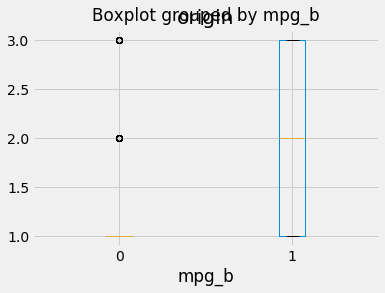

In [5]:
# code here and in additional cells if needed
auto_df.boxplot('weight', 'mpg_b')
##weight appears to be very different for low vs high mpg

auto_df.boxplot('acceleration', 'mpg_b')
##acceleration appears to maybe be different for low vs high mpg, the difference is small and could be due to chance

auto_df.boxplot('year', 'mpg_b')
##year appears to be very different for low vs high mpg probably because mpg increased for all cars as tech improved

auto_df.boxplot('displacement', 'mpg_b')
##displacement appears to be very different for low vs high mpg

auto_df.boxplot('origin', 'mpg_b')
#does not seem to be relevant, 1 across the board and therefore not predictive


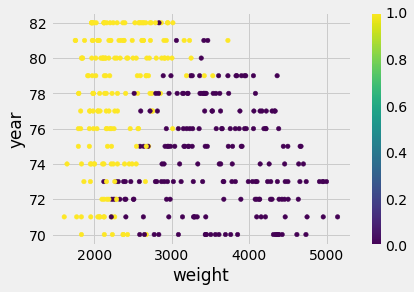

In [7]:
auto_df.plot.scatter('weight', 'year', c=auto_df['mpg_b'], colormap='viridis')

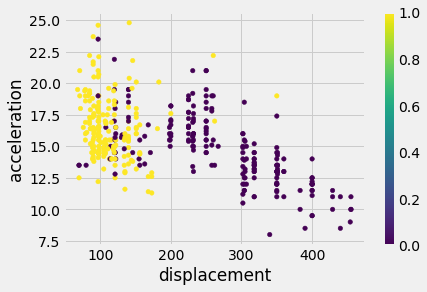

In [8]:
auto_df.plot.scatter('displacement', 'acceleration', c=auto_df['mpg_b'], colormap='viridis')

In [9]:
auto_df['mpg_b'] = auto_df['mpg_b'].astype(int)
##auto_df['horsepower'] = auto_df['horsepower'].astype(float) ##appears to be weird symbols in the dataset


mpg_model = ols("""auto_df['mpg_b'] ~ auto_df['weight']
                                    + auto_df['year']
                                    + auto_df['acceleration']
                                    + auto_df['displacement']
                                           """, data=auto_df).fit()
mpg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       auto_df['mpg_b']   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     160.2
Date:                Mon, 18 Feb 2019   Prob (F-statistic):           4.35e-81
Time:                        18:55:01   Log-Likelihood:                -95.586
No. Observations:                 397   AIC:                             201.2
Df Residuals:                     392   BIC:                             221.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6782      0.369     -1.839      0.067      -1.403       0.047
auto_df['weight']          -0.0003   5.36e-05     -4.932      0.000      -0.000      -0.000
auto_df['year']             0.0321      0.005      7.008      0.000       0.023       0.041
auto_df['acceleration']    -0.0153      0.007     -2.158      0.032      -0.029      -0.001
auto_df['displacement']    -0.0013      0.000     -2.799      0.005      -0.002      -0.000
==============================================================================
Omnibus:                       19.767   Durbin-Watson:                   1.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.267
Skew:                          -0.518   Prob(JB):                     3.97e-05
Kurtosis:                       2.612   Cond. No.                     7.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Graphically, displacement, year, and weight appear to be most useful in predicting mpg_b because of the large differences between groups shown through the box plots. In addition, the scatter plots show a clear difference in yellow vs. purple points for weight and displacement. There is some trend for year in the scatterplot as the higer the year, the more yellow dots there are compared to number of purple dots. However, it is not as clear of a distinction.

After running a regression with weight, year, acceleration, and displacement predicting mpg_b, it appears that all four of those variables are significant at the 0.05 alpha level, and weight, year, and displacement are significant at the 0.01 alpha level as determined through the p-values. Although one could argue that the coefficients for weight and displacement are really small, they are for one unit change in weight or displacement unit. Since those are large numbers with varaition, the effects are still relevant and good predictors.

#### Question 2.3 (Split the data, 3 points)

Split the data into a training set and a test set. Select **randomly** 50 rows of your data frame and extract their data into a test data frame. The rest of the 342 rows should form your training data frame.

In [11]:
# code here and in additional cells if needed
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [12]:
len(auto_df)

checkauto = auto_df.dropna()
len(checkauto)

##although the question says its 50 for test and 342 for training, 397-50 = 347 for training

397

In [13]:
train_df, test_df = train_test_split(auto_df, test_size=50)

len(test_df)

train_df.dtypes


mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
mpg_b             int64
dtype: object

#### Question 2.4 (kNN, 13 points)

The goal here is to construct a kNN algorithm that has high **accuracy** (proportion of test examples labeled correctly). Recall that you have to take into consideration: (i) the type of features (categorical, quantitative); (ii) the scaling of the features; (iii) the distance you use; (iv) the features in the model; (v) the number of neighbors, k.

You can choose to use only the variables that seem most asociated with **mpg_b** in Q2.2. Try several values of k, and report on your test errors. Which value of k performs best?


In [33]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def all_distances(X_train, point):
    """The distance between point (an array of numbers) and the numbers in row i of attribute data frame."""
    attributes = X_train.copy()
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point,axis=1)

def closest(X_train, Y_train, point, k):
    """A df containing the k closest rows in the training df to array 'point' """
    attributes=X_train.copy()
    attributes['Distance']=all_distances(attributes, point)
    attributes['Class']=Y_train
    attributes=attributes.sort_values('Distance')    
    topk = attributes.head(k)
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1's, and 0 otherwise."""
    ones = topkclasses[topkclasses.Class==1].shape[0]
    zeros = topkclasses[topkclasses.Class==0].shape[0]
    if ones > zeros:
        return 1
    else:
        return 0

# returns a data frame with X_test appended by a column of Class prediction
def classify(X_train,Y_train, X_test, k):
    """Classify data in X_test using k-nearest neighbor classification with the given training table."""
    #training = X_train
    n=X_test.shape[0] # the number of test cases
    
    pred_class = make_array()
    for i in np.arange(n):
        topkclasses = closest(X_train,Y_train, X_test.iloc[i], k)
        pred_class = np.append(pred_class,majority(topkclasses))
    
    report_df=X_test.copy()
    report_df['Class']=pred_class
    
    return report_df

##Taken from lecture 11 class demos

In [36]:
#drop strings/floats and drop acceleration because it was the least significant in Q2.2

train_df = train_df.drop(columns=['cylinders','horsepower', 'origin', 'name', 'mpg', 'acceleration'])
test_df = test_df.drop(columns=['cylinders','horsepower', 'origin', 'name', 'mpg', 'acceleration'])

displacement    int64
weight          int64
year            int64
mpg_b           int64
dtype: object

In [37]:
train_df.dtypes

displacement    int64
weight          int64
year            int64
mpg_b           int64
dtype: object

In [24]:
train_df['displacement'] = train_df['displacement'].astype(int)
test_df['displacement'] = test_df['displacement'].astype(int)

train_df['acceleration'] = train_df['acceleration'].astype(int)
test_df['acceleration'] = test_df['acceleration'].astype(int)

train_df['mpg_b'] = train_df['mpg_b'].astype(int)
test_df['mpg_b'] = test_df['mpg_b'].astype(int)

In [25]:
# code here and in additional cells if needed

X_train=train_df.drop(columns=['mpg_b'])
X_test=test_df.drop(columns=['mpg_b'])
Y_train=train_df.mpg_b
Y_test=test_df.mpg_b

train_df.head()
train_df.dtypes

displacement    int64
weight          int64
acceleration    int64
year            int64
mpg_b           int64
dtype: object

In [39]:
np.mean(Y_test==classify(X_train,Y_train, X_test, 3).Class)

0.92

In [40]:
np.mean(Y_test==classify(X_train,Y_train, X_test, 5).Class)

0.88

In [41]:
np.mean(Y_test==classify(X_train,Y_train, X_test, 7).Class)

0.84

In [42]:
np.mean(Y_test==classify(X_train,Y_train, X_test, 9).Class)

0.86

In [43]:
np.mean(Y_test==classify(X_train,Y_train, X_test, 11).Class)

0.84

It appears that lower values of k, specifically k=3 results in the highest accuracy score. The second highest is k=5, which is also fairly low.

I ran all the accuracy scores with different k's twice. First, with the addition of acceleration, and the second time with the same model but without acceleration. The accuracy scores did not change. The error can be attributed to differences in a different variable, perhaps horsepower which was not checked. 